# GSOC PINNDE Project
> Sijil Jose, Pushpalatha C. Bhat, Sergei Gleyzer, Harrison B. Prosper<br>
> Created: Tue May 27 2025<br>
> Updated: Thu May 29 2025 HBP: generalize sigma(t)<br>

## Introduction
This notebook defines a non-Gaussian 3D target distribution for use as an initial testbed for the GSoC 2025 PINNDE project. The goal of the PINNDE project is to deliver robust code to solve the reverse-time differential equation [1, 2, 3],
\begin{align}
    \frac{dx_t}{dt} &= \lambda_t \, x_t + \mu_t \, q(t, x_t), 
\end{align}
for the time-dependent vector $x_t \equiv x(t) \in \mathbb{R}^d$ using a physics-informed neural network  (PINN) [4,5, 6],
where
\begin{align}
   \lambda_t  \equiv \lambda(t) & = \frac{d\log\sigma_t}{dt}, \quad \sigma_t \equiv 
   \sigma(t), \\
   \mu_t  \equiv \mu(t) & =  \alpha_t \frac{d\log\alpha_t/\sigma_t}{dt}, \quad \alpha_t \equiv \alpha(t), 
\end{align}
and the functions $\alpha_t$ and $\sigma_t$ are chosen so that $\alpha_t / \sigma_t$ is monotonically decreasing with $t$ on the domain $t \in [0, 1]$.
The vector field $q(t, x_t)$ is given by
\begin{align}
        q(t, x_t)  & =  \int_{x_0 \in \mathbb{R}^d}  x_0 \, p(x_t | x_0) \, p(x_0) \, / \,
        \int_{x_0 \in \mathbb{R}^d}  p(x_t | x_0) \, p(x_0).
\end{align}
The field can be approximated via Monte Carlo (MC) integration [3],
\begin{align}
       q(t, x_t)  & \approx 
       \sum_{n=1}^N x_0^{(n)} \, w(x_t, x_0^{(n)}), 
        \quad\text{where } x_0 = x(t=0),\\
w(x_t, x_0^{(n)}) & = \frac{p(x_t | x_0^{(n)})}{\sum_{m=1}^N p(x_t | x_0^{(m)})},               
\end{align}
with $X_0 = \{ x_0^{(m)}\}_{m=1}^M$ a MC-generated sample that approximates $x_0 \sim p(x_0)$. The conditional probability density is given by
\begin{align}
p(x_t | x_0) 
 & \propto \exp \left(-\frac{1}{2}  v_t^2 \right),
\end{align}
where $v_t$ is the $d$-dimensional vector
\begin{align}
    v_t & = \frac{x_t - \alpha_t \, x_0}{\sigma_t} .
\end{align}
The vectors $z \equiv x(t=1)$ are sampled from a $d$-dimensional standard normal. 
If we set $\alpha_t = 1 - t$ and $\sigma_t = t$, we have $\lambda(t) = t^{-1}$ and $\mu(t) = -t^{-1}$ and, therefore,
\begin{align}
    \frac{dx_t}{dt} &= G(t, x_t), \quad G(t, x_t) = \frac{x_t  - q(t, x_t)}{t}.
\end{align}
The more general choice $\sigma_t = \sigma_0 + (1-\sigma_0) \, t$, which avoids the singularity at $t = 0$, leads to,
\begin{align}
    G(t, x_t) = \frac{(1 - \sigma_0) x_t  - q(t, x_t)}{\sigma_0 + (1-\sigma_0) \, t}.
\end{align}
A reasonable choice for $\sigma_0 \gt 0$ for the 1D problem is $\sigma_0 = 0.01$, but this should be viewed as a hyperparameter.

In this notebook, $d = 1$, and the diffusion equation is solved from $t = 1$ to $t = 0$ using a standard finite-difference method we call $\texttt{FlowDE}$. For the GSoC project $d = 3$ and the equation is to be solved using a PINN.

## Solution *ansatz* for PINN
For the PINNDE project, it is useful to include the initial conditions, $x(t=1) = z$, explicitly in the solution $x(t, z)$. We shall do so with the *ansatz* [7]
\begin{align}
    x(t, z)  & = z  + g_\theta(t, z) - g_\theta(1, z), \\
   \dot{x}(t, z) & = \dot{g}_\theta(t, z) .
\end{align} 
The function
$g_\theta(t, z)$ is a neural network with parameters $\theta$. The mapping $f : z \rightarrow x_0$ is then given by
\begin{align}
    x_0  & = f(z), \nonumber\\
         & = z  + g_\theta(0, z) - g_\theta(1, z) .
\end{align}
From this mapping, an explicit expression for the probability density $p(x_0)$ can be derived in terms of $p(z)$ using
\begin{align}
    p(z)  & = p(x_0) \left| \det J \right| , 
\end{align}
where $J = \nabla_{z} f(z)$ is the Jacobian matrix of the transformation, which can be computed with $\texttt{PyTorch}$ tools. Since $p(z)$ is known--it is a $d$-dimensional zero mean unit variance Gaussian, we can compute the unknown density using
\begin{align}
    p(x_0)  & = p(z) \left| \det J \right|^{-1} . 
\end{align}

### References
  1. Yang Song, Jascha Narain Sohl-Dickstein, Ben Poole, *Score-Based Generative Modeling through Stochastic Differential Equation*, International Conference on Learning Representations, 26 November 2020; https://arxiv.org/abs/2011.13456
  2. Cheng Lu†, Yuhao Zhou†, Fan Bao†, Jianfei Chen†, Chongxuan Li‡, Jun Zhu, *DPM-Solver: A Fast ODE Solver for Diffusion Probabilistic Model Sampling in Around 10 Steps*, arXiv:2206.00927v3, 13 Oct 2022.
  1. Yanfang Lui, Minglei Yang, Zezhong Zhang, Feng Bao, Yanzhao Cao, and Guannan Zhang, *Diffusion-Model-Assisted Supervised Learning of Generative Models for Density Estimation*, arXiv:2310.14458v1, 22 Oct 2023
  1. B. Moseley, see, for example, https://www.youtube.com/watch?v=IDIv92Z6Qvc.
  2. S. Cuomo *et al*., *Scientific Machine Learning through Physics-Informed Neural Networks: Where we are and What's next*, https://doi.org/10.48550/arXiv.2201.05624.
  3. Aditi S. Krishnapriyan, Amir Gholami, Shandian Zhe, Robert M. Kirby, Michael W. Mahoney, *Characterizing possible failure modes in physics-informed neural networks*, NIPS'21: Proceedings of the 35th International Conference on Neural Information Processing Systems; https://arxiv.org/abs/2109.01050.
  4. D. Mortari, *The Theory of Connections: Connecting Points*, Mathematics, vol. 5, no. 57, 2017.


In [1]:
# standard system modules
import os, sys

# standard module for array manipulation
import numpy as np

# standard module for high-quality plots
#import matplotlib as mp
import matplotlib.pyplot as plt
#mp.rcParams['text.usetex'] = True
#mp.rcParams['text.usetex'] = False
#mp.rcParams.update(mp.rcParamsDefault)
# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

from tqdm import tqdm
'''
# update fonts
FONTSIZE = 12
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)
'''
# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
#mp.rc('text', usetex=True)

# set device to cuda if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device: {str(DEVICE):4s}')

Available device: cuda


## Load 3D Distribution

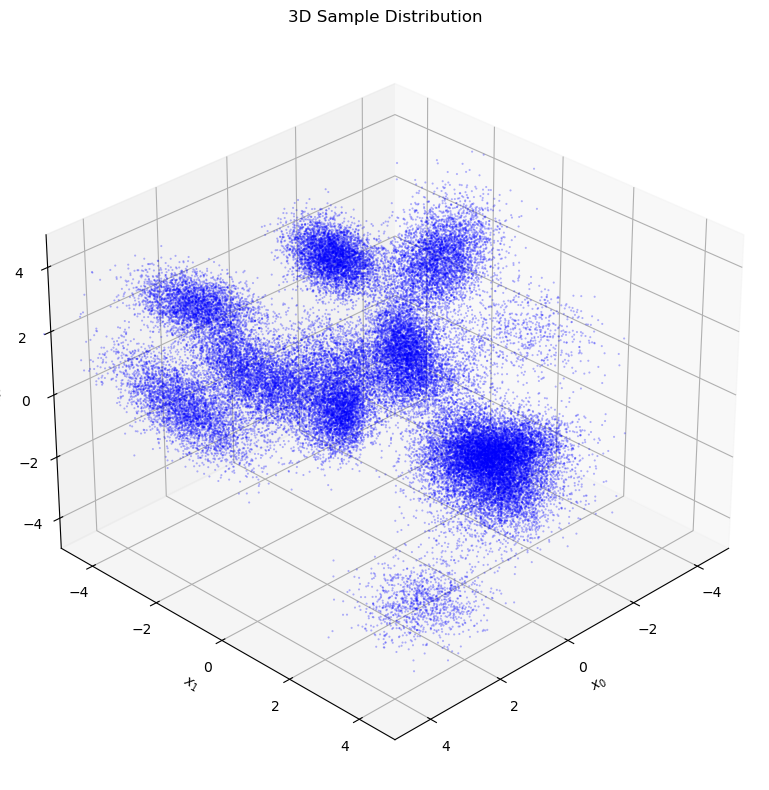

In [2]:
import numpy as np
import scipy.stats as st
import joblib
import matplotlib.pyplot as plt
import torch

# Parameters
N = 50000  #Sample size
LOAD = True  # Load precomputed GMM or generate new
K = 20  # Number of Gaussian components
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if LOAD:
    # Load precomputed 2D GMM parameters
    K, PROB, MU, SIGMA = joblib.load('X03d.pth')
else:
    # Generate new 3D GMM
    PROB = np.random.uniform(0, 1, K)
    PROB /= PROB.sum()  # Normalize to sum to 1

    # Means: Randomly sampled in [-4.5, 4.5] for both dimensions
    MU = np.random.uniform(-4.5, 4.5, (K, 3))

    # Covariance matrices: Random but symmetric positive-definite
    SIGMA = []
    for _ in range(K):
        A = np.random.uniform(-0.5, 0.5, (3, 3))
        SIGMA_i = A @ A.T + np.eye(3) * 0.1  # Ensure positive-definite
        SIGMA.append(SIGMA_i)
    
    joblib.dump([K, PROB, MU, SIGMA], 'X03d.pth')  # Save GMM parameters

# Define 3D GMM
GAUSSIANS = [st.multivariate_normal(mean=mu, cov=sigma) for mu, sigma in zip(MU, SIGMA)]
def fdist(x):
    return np.array([p * f.pdf(x) for p, f in zip(PROB, GAUSSIANS)]).sum(axis=0)

# Sample from the 2D GMM
k = np.random.choice(K, size=N, p=PROB)  # Choose components
samples_3d = np.array([np.random.multivariate_normal(MU[i], SIGMA[i]) for i in k])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot3D(samples, bins=50, 
           xmin=-5, xmax=5, 
           ymin=-5, ymax=5, 
           zmin=-5, zmax=5, 
           filename=None,
           title = "3D Sample Distribution",
           elev=30, azim=45,
           alpha=0.3,
           s=1):
    """
    Plot 3D sample distributions without true PDF contours
    
    Parameters:
    - samples: Array of shape [N, 3] containing 3D samples
    - bins: Number of bins for histogram (not used in current implementation)
    - xmin, xmax, ymin, ymax, zmin, zmax: Axis limits
    - filename: Output filename (None to disable saving)
    - elev, azim: 3D view angles
    - alpha: Transparency of points (0-1)
    - s: Size of points
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Set viewing angles
    ax.view_init(elev=elev, azim=azim)
    
    # Simple 3D scatter plot of samples
    ax.scatter(samples[:,0], samples[:,1], samples[:,2], 
               s=s, alpha=alpha, c='blue', marker='.')

    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    ax.set_title(title)
    
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()

# Example usage:
# samples_3d = np.random.randn(10000, 3)  # Your 3D samples
# def fdist_3d(x): return np.exp(-0.5*np.sum(x**2, axis=1))/(2*np.pi)**1.5  # 3D Gaussian
# plot3D(samples_3d, f=fdist_3d)
# Example usage:
X0 = torch.tensor(samples_3d, dtype=torch.float32).to(DEVICE)
plot3D(samples_3d)  # Where samples_3d.shape = [N,3] and fdist_3d is a 3D PDF function

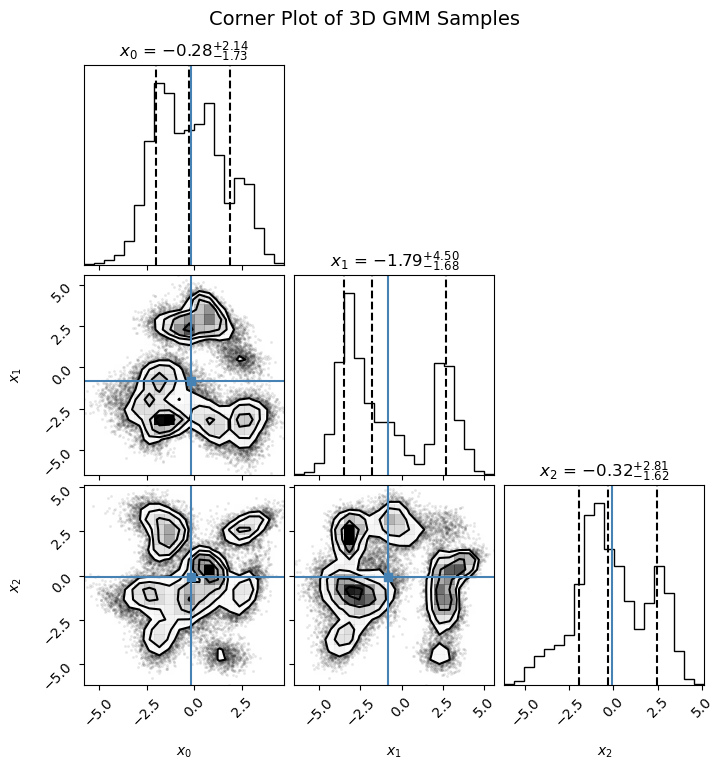

In [3]:
import corner

# Generate corner plot
fig = corner.corner(
    samples_3d,
    labels=["$x_0$", "$x_1$","$x_2$" ],
    truths=np.mean(samples_3d, axis=0),  # Optional: Mark true means
    quantiles=[0.16, 0.5, 0.84],  # Show 1-sigma ranges
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

plt.suptitle("Corner Plot of 3D GMM Samples", y=1.02, fontsize=14)
#plt.savefig("corner_plot.png", bbox_inches="tight")
plt.show()

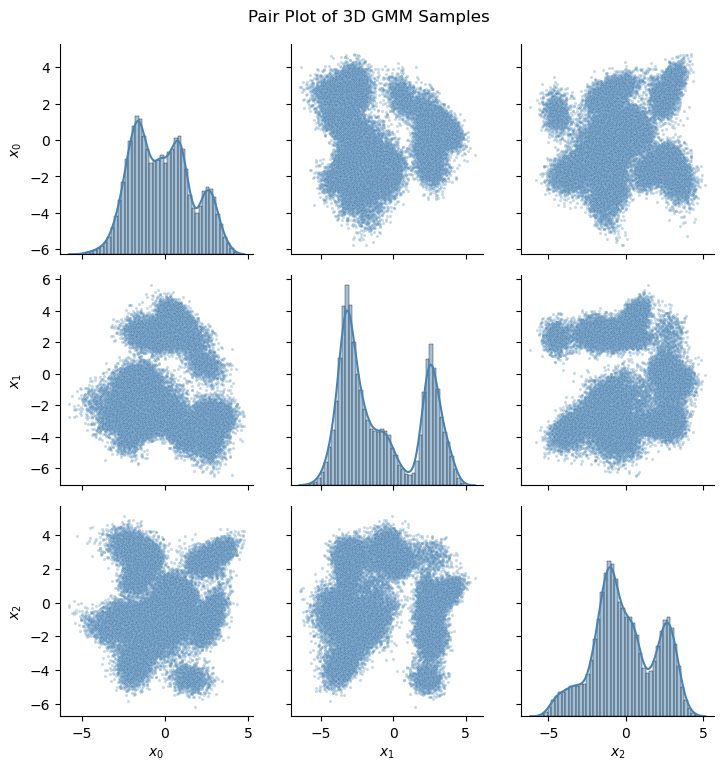

In [4]:
import seaborn as sns

# Create a DataFrame for seaborn
import pandas as pd
df = pd.DataFrame(samples_3d, columns=["$x_0$", "$x_1$", "$x_2$"])

# Plot
g = sns.PairGrid(df)
g.map_diag(sns.histplot, kde=True, bins=50, color="steelblue")  # Diagonal: KDE + Histogram
g.map_offdiag(sns.scatterplot, s=5, alpha=0.3, color="steelblue")  # Off-diagonal: Scatter
g.fig.suptitle("Pair Plot of 3D GMM Samples", y=1.02)

#plt.savefig("pair_plot_3d.png", bbox_inches="tight")
plt.show()

## q-Vector Field: $q(t, x_t)$

Some version of the class could be used in the PINN objective function.

In [5]:
class qVectorField(nn.Module):    
    '''
    Compute a Monte Carlo approximation of the q vector field of the reverse-time 
    diffusion equation, 
    
     dx/dt = [(1-s0)*xt - q(t, xt)] / [s0 + (1-s0)*t],

    where xt = x(t) is a d-dimensional vector and q(t, xt) is a d-dimensional 
    time-dependent vector field and s0 is that value of sigma(t) at t=0.
     
    The vector field q(t, xt) is defined by a d-dimensional integral which is 
    approximated with a Monte Carlo (MC)-generated sample, x0, of shape (M, d),
    where M is the sample size and d is the dimension of the vector space.

    Example
    -------

    q = qVectorField(x0)
        :  :
    qt = q(t, xt)
    '''
    def __init__(self, x0, sigma0=1e-2, debug=False):

        super().__init__()

        assert(x0.ndim==2)
        # x0.shape: (M, d)
        
        # change shape of x0 from (M, d) to (1, M, d)
        # so that broadcasting works correctly later.
        self.x0 = x0.unsqueeze(0)

        self.sigma0 = sigma0
        self.debug  = debug

        if debug:
            print('qVectorField.__init__: x0.shape', x0.shape)

    def set_debug(self, debug=True):
        self.debug = debug
        
    def forward(self, t, xt):
        
        assert(xt.ndim==2)

        if type(t) == type(xt):
            assert(t.ndim==2)

            # change shape of t so that broadcasting works correctly
            t = t.unsqueeze(1)
            # t.shape: (N, 1) => (N, 1, 1)
            
        debug = self.debug
        x0 = self.x0
        sigma0 = self.sigma0
        
        # change shape xt so that broadcasting works correctly
        xt = xt.unsqueeze(1)
        # xt.shape: (N, d) => (N, 1, d)

        if debug:
            print('qVectorField(BEGIN)')
            print('  qVectorField: xt.shape', xt.shape)
            print('  qVectorField: x0.shape', x0.shape)

        alphat = 1 - t
        sigmat = sigma0 + (1 - sigma0) * t
        vt = (xt - alphat * x0) / sigmat
        
        if torch.isnan(vt).any():
            raise ValueError("vt contains at least one NAN")
            
        # vt.shape: (N, M, d)
        if debug:
            print('  qVectorField: vt.shape', vt.shape)
            print('  qVectorField: vt', vt)
        
        # sum over arguments of exponential, that is, 
        # over the d-dimensions of each element in x0, 
        # so that we get the product of d normal densities.    
        
        '''
        v2 = (vt*vt).sum(dim=-1)
        vv = torch.where(v2 < 207, v2, 207)        ## why not use the logsumexp for greater stability
        if torch.isnan(vv).any():
            raise ValueError("vv contains at least one NAN")

        if debug:
            print('  qVectorField: vv.shape', vv.shape)
 
        # compute unnormalized probability densities.
        pt = torch.exp(-vv/2)
        if torch.isnan(pt).any():
            raise ValueError("pt contains at least one NAN")

        # pt.shape: (N, M)
        if debug:
            print('  qVectorField: pt.shape', pt.shape)

        # sum over the M d-dimensional Gaussian densities
        ptsum = pt.sum(dim=-1)
        # ptsum.shape: (N, )
        if torch.isnan(ptsum).any():
            raise ValueError("ptsum contains at least one NAN")

        # protect sum against divide by zero
        pt_sum = torch.where(ptsum < 1.e-44, 1, ptsum).unsqueeze(-1)
        # pt_sum.shape: (N, 1)
        if torch.isnan(ptsum).any():
            raise ValueError("ptsum contains at least one NAN")
            
        # compute weights
        wt = pt / pt_sum
        '''


        v2 = (vt * vt).sum(dim=-1)
        log_weights = -0.5 * v2
        log_weights = log_weights - torch.logsumexp(log_weights, dim=-1, keepdim=True)
        wt = torch.exp(log_weights)

        
        # wt.shape: (N, M)
        if torch.isnan(wt).any():
            print('pt')
            print(pt)
            print()
            print('pt_sum')
            print(pt_sum)
            print()
            print('wt')
            print(wt)
            raise ValueError("wt contains at least one NAN")

        if debug:
            print('  qVectorField: wt.shape', wt.shape)
        
        # sum over the sample of M weighted elements of x0
        # x0.shape: (1, M, d)
        # wt.shape: (N, M) => (N, M, 1)
        x0_wt = x0 * wt.unsqueeze(-1)
        # x0_wt.shape: (N, M, d)
        
        if torch.isnan(x0_wt).any():
            raise ValueError("x0_wt contains at least one NAN")

        if debug:
            print('  qVectorField: x0_wt.shape', x0_wt.shape)

        # sum over the MC sample dimension of x0_wt
        qt = x0_wt.sum(dim=1)
        # qt.shape: (N, d)
        if torch.isnan(qt).any():
            raise ValueError("qt contains at least one NAN")

        if debug:
            print('  qVectorField: qt.shape', qt.shape)
            print('qVectorField(END)')
            
        return qt

    def G(self, t, xt):
        sigma0 = self.sigma0
        sigmat = sigma0 + (1 - sigma0) * t
        qt = self(t, xt)
        return ((1 - sigma0) * xt - qt) / sigmat

    def G_num(self, t, xt):
        sigma0 = self.sigma0
        qt = self(t, xt)
        return ((1 - sigma0) * xt - qt) 


## Test $\texttt{PyTorch}$-based Finite-Difference Solver

In [6]:
def get_normal_sample(x):
    try:
        x = x.cpu()  # we may be on a GPU, so must send to CPU to use numpy
    except:
        pass
    means = np.zeros_like(x)
    scales = np.ones_like(x)
    return torch.Tensor(np.random.normal(loc=means, scale=scales))
        
def get_target_sample(x, size=4000):
    ii = np.random.randint(0, len(x)-1, size)
    return torch.Tensor(x[ii])

class FlowDE(nn.Module):    
    '''
    Given standard normal vectors z = x(t=1), compute target vectors 
    x0 = x(t=0) by mapping z to x0 deterministically. x0, which is 
    of shape (M, d), where M is the Monte Carlo (MC) sample size and d 
    the dimension of the vector x0 = x(0), is used to compute a MC 
    approximation of the q vector field. The tensor z is of shape (N, d), 
    where N is the number of points sampled from a d-dimensionbal 
    standard normal. 

    Utility functions
    =================
    1. get_normal_sample(X0) returns a tensor z = x(1), with the same shape 
    as X0, whose elements are sampled from a diagonal d-dimensional Gaussian. 

    2. get_target_sample(X0, M) returns a sample of points, x0, of size M 
    from X0, which will be used to approximate the q vector field.

    Example
    -------
    N = 4000
    M = 4000
    
    z  = get_normal_sample(X0[:N]).to(DEVICE)
    x0 = get_target_sample(X0, M).to(DEVICE)
    
    flow = FlowDE(x0)

    y = flow(z)
    
    '''
    def __init__(self, x0, sigma0=1e-2, T=250, savepath=False, debug=False, 
                 device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        
        # x0: MC sample of shape (M, d)
        # T:  number of time steps in [1, 0]
        
        super().__init__()

        assert(x0.ndim==2)
        
        self.q = qVectorField(x0, sigma0, debug).to(device)
        
        if T < 4: T = 4

        self.T = T
        self.h = 1/T # step size
        self.savepath = savepath
        self.debug = debug

    def set_debug(self, debug=True):
        self.debug = debug

    def G(self, t, xt):
        # t is either a float or a 2D tensor of shape (N, 1)
        # xt.shape: (N, d)
        return self.q.G(t, xt)

    def forward(self, z):
        assert(z.ndim==2)
        
        debug = self.debug

        savepath = self.savepath
        T = self.T
        h = self.h
        t = 1      # initial "time"
        xt= z      # initial "state"
        
        if debug:
            print('FlowDE.forward: xt.shape', xt.shape)
            print('FlowDE.forward: t', t)
        '''
        if savepath:
            y = [xt]
        '''
        
        G1 = self.G(t, xt)
        times = []
        y = []
        for i in tqdm(range(T)):
            t -= h
            
            if t < 0: 
                break
                
            if debug:
                print('FlowDE.forward: t', t)
                print('FlowDE.forward: xt.shape', xt.shape) 
                print('FlowDE.forward: G1.shape', G1.shape)
                
            G2 = self.G(t, xt - G1 * h)

            xt = xt - (G1 + G2) * h / 2
            
            G1 = G2.detach().clone()

            if savepath:
                y.append(xt.cpu().numpy())
                times.append(t)

        if savepath:
            return y , times
        else:
            return xt

100%|█████████▉| 249/250 [00:02<00:00, 83.19it/s]


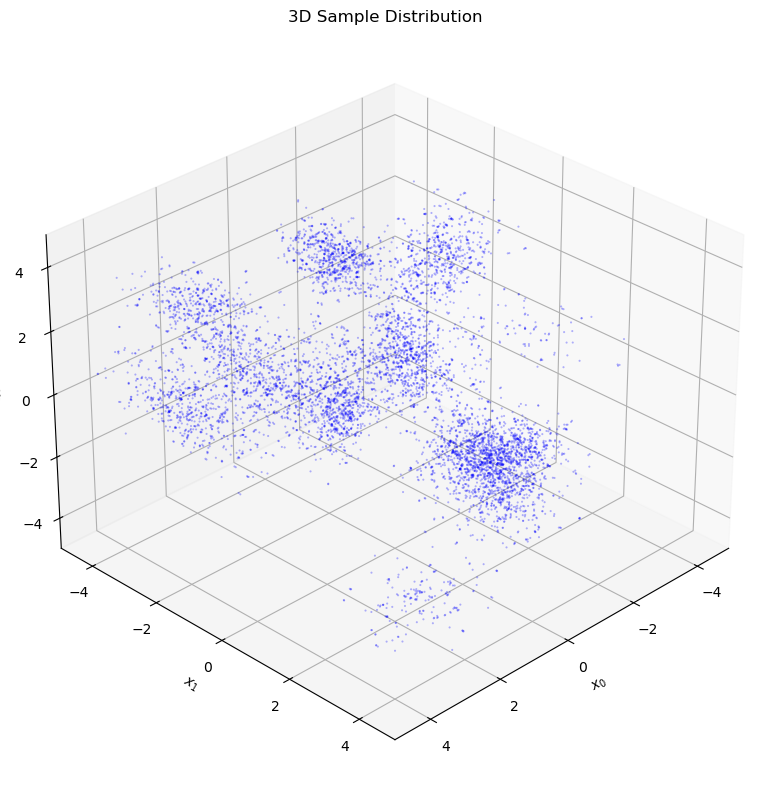

In [7]:
N = 8000
M = 9000

x0 = get_target_sample(X0, M).to(DEVICE)
flow = FlowDE(x0,T= 250, savepath=True)

z = get_normal_sample(X0[:N]).to(DEVICE)
y,times = flow(z)

plot3D(y[-1])

In [8]:
x0.shape

torch.Size([9000, 3])

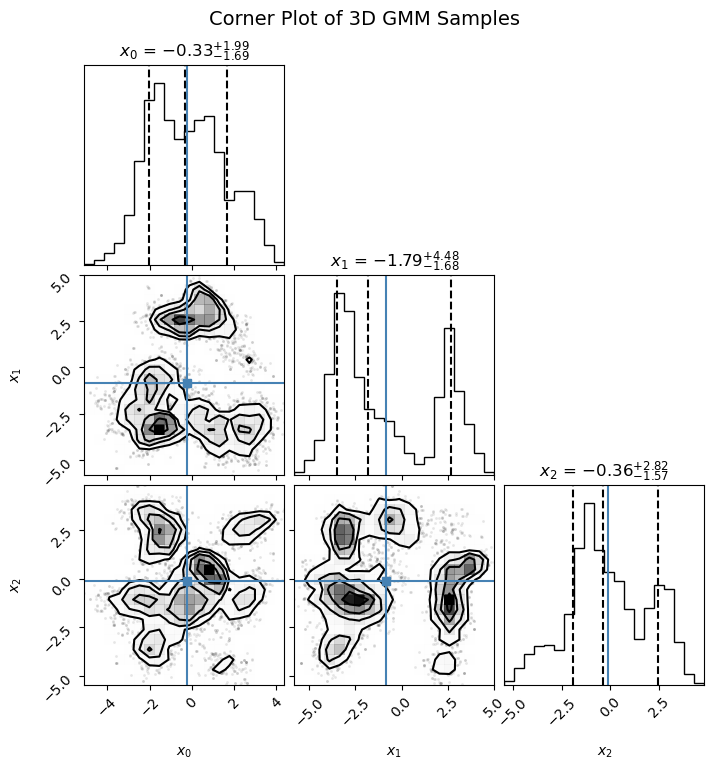

In [9]:
#Generate corner plot
fig = corner.corner(
    y[-1],
    labels=["$x_0$", "$x_1$", "$x_2$"],
    truths=np.mean(y[-1], axis=0),  # Optional: Mark true means
    quantiles=[0.16, 0.5, 0.84],  # Show 1-sigma ranges
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

plt.suptitle("Corner Plot of 3D GMM Samples", y=1.02, fontsize=14)
#plt.savefig("corner_plot.png", bbox_inches="tight")
plt.show()

In [10]:
#z = torch.linspace(-5,5,N)[:,None].to(DEVICE)
#y,times = flow(z)

## Using Physics informed neural networks to solve the reverse time ODE equation 

In [11]:
times[-1] = 0.0

In [12]:
z[0][None,:]

tensor([[ 0.5539, -1.2618,  1.2075]], device='cuda:0')

In [13]:
z[0].dtype

torch.float32

In [14]:
def set_seed(seed=42):
    '''
    Seeding the random variables for reproducibility
    '''
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

In [15]:
class PhysicsNN(nn.Module):
    def __init__(self, x0, sigma0=1e-2):
        super(PhysicsNN, self).__init__()
        self.q = qVectorField(x0, debug=False).to(device)
        self.z = z.to(device)
        
        # More stable architecture
        self.net = nn.Sequential(
            nn.Linear(4, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 3),
        ).float()
        
        # Initialize weights properly
        #self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('tanh'))
                nn.init.normal_(m.bias, mean=0, std=0.1)

    def forward(self, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:

        x = torch.cat([t, z], dim=1)
        
        return self.net(x)


In [16]:
'''
def x_function(model: PhysicsNN, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
    """
    This function evaluates the neural network based solution anzat for the solution of the reverse time diffusion equation
    """
    assert torch.isfinite(z).all()
    t_1 = torch.ones(t.shape, device = DEVICE)
    out = z + model(t,z) - model (t_1, z)
    if not torch.isfinite(out).all():
        raise ValueError("x_function returned NaN or Inf")
    return out
'''

'\ndef x_function(model: PhysicsNN, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:\n    """\n    This function evaluates the neural network based solution anzat for the solution of the reverse time diffusion equation\n    """\n    assert torch.isfinite(z).all()\n    t_1 = torch.ones(t.shape, device = DEVICE)\n    out = z + model(t,z) - model (t_1, z)\n    if not torch.isfinite(out).all():\n        raise ValueError("x_function returned NaN or Inf")\n    return out\n'

In [17]:

def x_function(model: PhysicsNN, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
    t_1 = torch.ones_like(t)
    
    out1 = model(t, z)
    out2 = model(t_1, z)

    if not torch.isfinite(out1).all():
        print("model(t, z) has NaN or Inf")
        print("t =", t)
        print("z =", z)
        print("model(t, z) =", out1)
        raise ValueError("model(t, z) returned NaN or Inf")

    if not torch.isfinite(out2).all():
        print("model(1, z) has NaN or Inf")
        print("t_1 =", t_1)
        print("z =", z)
        print("model(t_1, z) =", out2)
        raise ValueError("model(t_1, z) returned NaN or Inf")

    out = z + out1 - out2

    if not torch.isfinite(out).all():
        print("Final x_function output has NaN or Inf")
        print("z =", z)
        print("model(t, z) =", out1)
        print("model(1, z) =", out2)
        print("x =", out)
        raise ValueError("x_function returned NaN or Inf")

    return out

In [18]:

def derivative(model: PhysicsNN, t_f: torch.Tensor, z: torch.Tensor ,order: int = 1) -> torch.Tensor:
    """
    This function calculates the derivative of the Anzat at t_f
    """
    t_f.requires_grad_(True)
    dy = model(t_f, z)
    for i in range(order):
        dy = torch.autograd.grad(
            dy, t_f, grad_outputs = torch.ones_like(t_f), create_graph=True, retain_graph=True
        )[0]
    return dy


In [19]:
def derivative(model: PhysicsNN, t_f: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
    """
    Computes the Jacobian ∂x/∂t_f for batch inputs.
    Output shape: [N, D, 1] if model output is [N, D] and t_f is [N, 1].
    """
    t_f = t_f.clone().detach().requires_grad_(True)
    output = model(t_f, z)  # [N, D]
    N, D = output.shape

    jac = []
    for d in range(D):
        grads = torch.autograd.grad(
            outputs=output[:, d],
            inputs=t_f,
            grad_outputs=torch.ones_like(output[:, d]),
            create_graph=True,
            retain_graph=True
        )[0]  # [N, 1]
        jac.append(grads)

    return torch.stack(jac, dim=1)[:,:,0]  # [N, D, 1]

In [20]:

def f(model: PhysicsNN, t_f: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
    """
    This function evaluates the ODE governing the reverse flow at times t for inputs z
    
    """
    x = x_function(model, t_f,z)
    dxdt = derivative(model, t_f, z)
    q_val = model.q.G(t_f, x)
    if not (torch.isfinite(dxdt).all() and torch.isfinite(q_val).all()):
        raise ValueError("NaN in derivative or q.G")   
    f = t_f*dxdt - t_f*q_val
    
    return f

In [21]:
def loss_function(model: PhysicsNN, t_f: torch.Tensor, z : torch.Tensor, t_u: torch.Tensor, z_u:torch.Tensor, x_u:torch.Tensor) -> torch.Tensor:
    # Loss associated with the physics governing the model
    MSE_f = f(model, t_f, z).pow(2).mean()

    #Loss associated with training data
    MSE_u = (x_function(model, t_u, z_u)- x_u).pow(2).mean()

    return MSE_u + MSE_f

In [22]:
def loss_function_physics(model: PhysicsNN, t_f: torch.Tensor, z : torch.Tensor) -> torch.Tensor:
    # Loss associated with the physics governing the model
    MSE_f = f(model, t_f, z).pow(2).mean()

    return MSE_f 

In [23]:
iter = 0  # Make sure `iter` is defined globally at module level

def closure(model: PhysicsNN, t_f: torch.Tensor, z: torch.Tensor,
            t_u: torch.Tensor, z_u: torch.Tensor, x_u: torch.Tensor) -> torch.Tensor:
    """
    Closure function required by LBFGS optimizer.
    """
    #model.load_state_dict(torch.load('/pscratch/sd/s/sijilj/PINN/RFDE_model_parameters.pth'))
    global iter
    model.zero_grad()  #  Move this line *inside* the closure, not passed in
    loss = loss_function(model, t_f, z, t_u, z_u, x_u)

    if torch.isnan(loss) or torch.isinf(loss):
        print("Closure encountered NaN or Inf in loss.")
        return torch.tensor(0.0, requires_grad=True).to(DEVICE)

    loss.backward()

    iter += 1
    if iter % 1000 == 0:
        print(f"Iteration: {iter}, Loss: {loss.item()}")
        torch.save(model.state_dict(), '/pscratch/sd/s/sijilj/PINN/RFDE_model_parameters_3D.pth')
    #print(f"Iteration: {iter}, Loss: {loss.item()}")
    return loss


In [24]:
def prepare_3d_data(t_u, z_u, x_u):
    """Prepares 2D-compatible training data with x_u shape [T,N,2]"""
    # t_u: [T], z_u: [N,2], x_u: [T,N,2]
    t_tensor = torch.tensor(t_u, dtype=torch.float32)  # [T]
    z_tensor = torch.tensor(z_u, dtype=torch.float32)  # [N,3]
    x_tensor = torch.tensor(x_u, dtype=torch.float32)  # [T,N,3]
    
    # Create all time-space combinations
    T_flat = t_tensor.repeat_interleave(z_tensor.shape[0])[:, None]  # [T*N,1]
    Z_flat = z_tensor.repeat(t_tensor.shape[0], 1)  # [T*N,3]
    
    # Flatten x_u to match [T*N,3]
    X_flat = x_tensor.reshape(-1, 3)  # [T*N,3]
    return T_flat.to(DEVICE), Z_flat.to(DEVICE), X_flat.to(DEVICE)


In [25]:
from functools import partial
from torch.utils.data import TensorDataset, DataLoader

def train(model: PhysicsNN, z_full, t_u, z_u, x_u, ramp_steps=5, initial_z_frac=0.1,lr_target=1.0,lr_warmup_factor=0.1):
    """
    Trains the model using the LBFGS optimizer with closure.
    """
    #model.load_state_dict(torch.load('/pscratch/sd/s/sijilj/PINN/RFDE_model_parameters_3D.pth'))


    T_u_flat, Z_u_flat, X_u_flat = prepare_3d_data(t_u, z_u, x_u)


    '''
    # Collocation grid
    t = np.linspace(0, 1, 100)**2
    T, Z = np.meshgrid(t, z)
    T_flat = torch.Tensor(T).flatten()[:, None].float().to(DEVICE)
    Z_flat = torch.Tensor(Z).flatten()[:, None].float().to(DEVICE)
    del T, Z
    '''
    t = np.linspace(0, 1, 100)
    total_z = len(z_full)
    z_sizes = [int(initial_z_frac * total_z + (i / (ramp_steps - 1)) * (total_z - initial_z_frac * total_z)) for i in range(ramp_steps)]
    lrs = [ (lr_target + 1e-5 )- lr_target * (lr_warmup_factor + (i / (ramp_steps - 1)) * (1 - lr_warmup_factor)) for i in range(ramp_steps)]
    for i, (z_size, lr) in enumerate(zip(z_sizes, lrs)):
        z_subset = z_full[:z_size]
        # Prepare 2D collocation points - fixed repetition pattern
        T_flat = torch.tensor(t, dtype=torch.float32).repeat_interleave(len(z_subset))[:, None]  # [T*N,1]
        #Z_flat = torch.tensor(z_subset, device=DEVICE, dtype=torch.float32).repeat(len(t), 1)  # [T*N,2]
        Z_flat = z_subset.clone().detach().to(dtype=torch.float32).repeat(len(t), 1)

        colloc_dataset = TensorDataset(T_flat, Z_flat)
        colloc_loader = DataLoader(colloc_dataset, batch_size=55000, shuffle=True)
        

        print(f"\n Ramp Step {i+1}/{ramp_steps} — z_size: {z_size}, learning rate: {lr:.5f}")

        # Create LBFGS optimizer
        optimizer = torch.optim.LBFGS(model.parameters(),
                                  lr= lr,
                                  max_iter=10000,
                                  max_eval=10000,
                                  history_size=100,
                                  tolerance_grad=1e-100,
                                  tolerance_change=1e-100,
                                  line_search_fn="strong_wolfe")

        
        for batch_idx, (T_batch, Z_batch) in enumerate(colloc_loader):
            T_batch, Z_batch = T_batch.to(DEVICE), Z_batch.to(DEVICE)
            closure_fn = lambda: closure(model, T_batch, Z_batch, T_u_flat, Z_u_flat, X_u_flat)
            optimizer.step(closure_fn)



        #  Fix: Don't pass optimizer to closure — it's not required by PyTorch
        #closure_fn = lambda: closure(model, T_flat, Z_flat, T_u_flat, Z_u_flat, X_u_flat)
        torch.save(model.state_dict(), '/pscratch/sd/s/sijilj/PINN/RFDE_model_parameters_3D.pth')
        # Run LBFGS optimization loop
        optimizer.step(closure_fn)

    return model, []  # loss_list was unused in this LBFGS form

In [26]:
from functools import partial
def train_adam(model: PhysicsNN, z_full, t_u, z_u, x_u, ramp_steps=5, initial_z_frac=0.1,lr_target=1.0,lr_warmup_factor=0.1):
    """
    Trains the model using the LBFGS optimizer with closure.
    """
    #model.load_state_dict(torch.load('/pscratch/sd/s/sijilj/PINN/RFDE_model_parameters_3D.pth'))
    epoch = 5000
    # Training data grid
    #T_u, Z_u = np.meshgrid(t_u, z_u)

    T_u_flat, Z_u_flat, X_u_flat = prepare_3d_data(t_u, z_u, x_u)


    loss_list = []
    t = (np.linspace(0, 1, 100))
    total_z = len(z_full)
    z_sizes = [int(initial_z_frac * total_z + (i / (ramp_steps - 1)) * (total_z - initial_z_frac * total_z)) for i in range(ramp_steps)]
    lrs = [ (lr_target + 1e-5 )- lr_target * (lr_warmup_factor + (i / (ramp_steps - 1)) * (1 - lr_warmup_factor)) for i in range(ramp_steps)]
    for i, (z_size, lr) in enumerate(zip(z_sizes, lrs)):
        z_subset = z_full[:z_size]
        # Prepare 3D collocation points - fixed repetition pattern
        T_flat = torch.tensor(t, dtype=torch.float32).repeat_interleave(len(z_subset))[:, None]  # [T*N,1]
        #Z_flat = torch.tensor(z_subset, device=DEVICE, dtype=torch.float32).repeat(len(t), 1)  # [T*N,3]
        Z_flat = z_subset.clone().detach().to(dtype=torch.float32).repeat(len(t), 1)
        print(Z_flat.shape)
        
        
        
        colloc_dataset = TensorDataset(T_flat, Z_flat)
        colloc_loader = DataLoader(colloc_dataset, batch_size=55000, shuffle=True)

        print(f"\n Ramp Step {i+1}/{ramp_steps} — z_size: {z_size}, learning rate: {lr:.5f}")
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(epoch):
            for batch_idx, (T_batch, Z_batch) in enumerate(colloc_loader):
                T_batch, Z_batch = T_batch.to(DEVICE), Z_batch.to(DEVICE)
            optimizer.zero_grad()
            loss = loss_function(model, T_batch,  Z_batch, T_u_flat, Z_u_flat, X_u_flat )
            loss.backward()
            optimizer.step()
            if (epoch % 1000 == 0) and (epoch > 1):
              loss_list.append(loss.item())
              # Sample collocation points
              #t_eval = torch.rand(1000, 1)                           
              #z_eval = get_normal_sample(t_eval).to(DEVICE)          
                # Evaluation part
                # Evaluate the model
              #eval_loss = loss_function_physics(model,t_eval.to(device) , z_eval.to(device))
              print(f"Epoch: {epoch}, Loss: {loss.item()}")#, Loss_eval : {eval_loss.item()}")
              torch.save(model.state_dict(), '/pscratch/sd/s/sijilj/PINN/RFDE_model_parameters_3D.pth')
        

    return model, loss_list

In [27]:
N = 1500
#z_train = get_normal_sample(X0[:N])
z_0_test = np.linspace(-5,5,N)
z_1_test = np.linspace(-5,5,N)
z_2_test = np.linspace(-5,5,N)

z_train = np.array([z_0_test, z_1_test, z_2_test]).T
#z_train = np.linspace(-5,5,N)

#np.random.shuffle(z_train)

z_train = torch.Tensor(z_train[:])

In [28]:
z_train.shape

torch.Size([1500, 3])

In [29]:
t_data = np.array(times)
z_data = np.array(z.cpu())
x_data = np.array(y)

In [30]:
x_data.shape

(249, 8000, 3)

In [31]:
set_seed(42)

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Training on GPU.")
else:
    device = torch.device("cpu") 
    print("GPU is not available. Training on CPU.")
# Instantiating the model

model = PhysicsNN(x0).to(device)
model.load_state_dict(torch.load('/pscratch/sd/s/sijilj/PINN/RFDE_model_parameters_3D.pth'))


model, loss_list = train_adam(model,z_train, t_data, z_data, x_data, ramp_steps=5, initial_z_frac=1, lr_target=3e-4, lr_warmup_factor=0.1 )


GPU is available. Training on GPU.
torch.Size([150000, 3])

 Ramp Step 1/5 — z_size: 1500, learning rate: 0.00028
Epoch: 0, Loss: 0.12086204439401627
Epoch: 1000, Loss: 0.004127565771341324
Epoch: 2000, Loss: 0.003672603517770767
Epoch: 3000, Loss: 0.0034467014484107494
Epoch: 4000, Loss: 0.0033149344380944967
torch.Size([150000, 3])

 Ramp Step 2/5 — z_size: 1500, learning rate: 0.00021
Epoch: 0, Loss: 0.0031909961253404617
Epoch: 1000, Loss: 0.0031415526755154133
Epoch: 2000, Loss: 0.0031031821854412556
Epoch: 3000, Loss: 0.003105791751295328


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fb2dc2d1760>>
Traceback (most recent call last):
  File "/global/homes/s/sijilj/anaconda3/envs/cmb/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [32]:
! nvidia-smi

Sun Jul 27 08:07:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:C3:00.0 Off |                    0 |
| N/A   48C    P0             47W /  250W |   22583MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## visualising the G function

In [33]:
set_seed(42)

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Training on GPU.")
else:
    device = torch.device("cpu") 
    print("GPU is not available. Training on CPU.")
# Instantiating the model

model = PhysicsNN(x0).to(device)
model.load_state_dict(torch.load('/pscratch/sd/s/sijilj/PINN/RFDE_model_parameters_3D.pth'))


GPU is available. Training on GPU.


<All keys matched successfully>

torch.Size([10000, 3])
torch.Size([10000, 1])


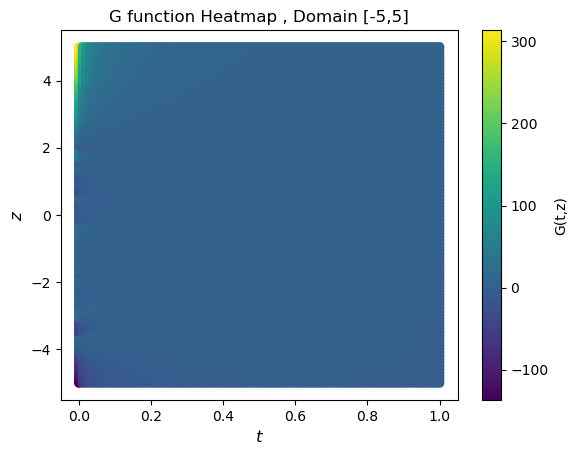

In [34]:
t = np.linspace(0, 1, 100)
z_0_test = np.linspace(-5,5,100)
z_1_test = np.linspace(-5,5,100)
z_2_test = np.linspace(-5,5,100)

z_test = np.array([z_0_test, z_1_test, z_2_test]).T

T_flat = torch.tensor(t, device=DEVICE, dtype=torch.float32).repeat_interleave(len(z_test))[:, None]  # [T*N,1]
Z_flat = torch.tensor(z_test, device=DEVICE, dtype=torch.float32).repeat(len(t), 1)  # [T*N,3]
print(Z_flat.shape)
print(T_flat.shape)

residue = q_val = model.q.G(T_flat, Z_flat)

plt.scatter(T_flat.detach().to('cpu').numpy()[:,0], Z_flat.detach().to('cpu').numpy()[:,0], c=(residue.detach().to('cpu').numpy()[:,0]), cmap='viridis')
plt.colorbar(label='G(t,z)')
plt.xlabel('$t$', fontsize=12)
plt.ylabel('$z$', fontsize=12)
plt.title('G function Heatmap , Domain [-5,5]')
plt.show()


In [35]:
residue.shape

torch.Size([10000, 3])

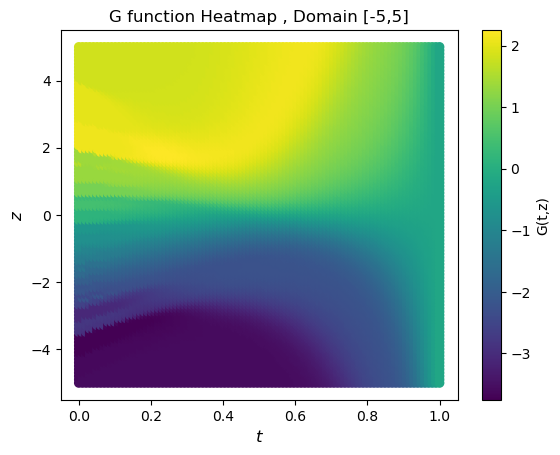

In [36]:
residue = q_val = model.q(T_flat, Z_flat)

plt.scatter(T_flat.detach().to('cpu').numpy()[:,0], Z_flat.detach().to('cpu').numpy()[:,0], c=(residue.detach().to('cpu').numpy()[:,0]), cmap='viridis')
plt.colorbar(label='G(t,z)')
plt.xlabel('$t$', fontsize=12)
plt.ylabel('$z$', fontsize=12)
plt.title('G function Heatmap , Domain [-5,5]')
plt.show()

In [37]:
residue.max()

tensor(3.4387, device='cuda:0')

In [38]:
residue.min()

tensor(-5.4691, device='cuda:0')

In [39]:
torch.any(residue < 2)

tensor(True, device='cuda:0')

Testing the PINN with numerical solver for just one initial point from the standard normal distribution 

100%|█████████▉| 249/250 [00:00<00:00, 1284.92it/s]


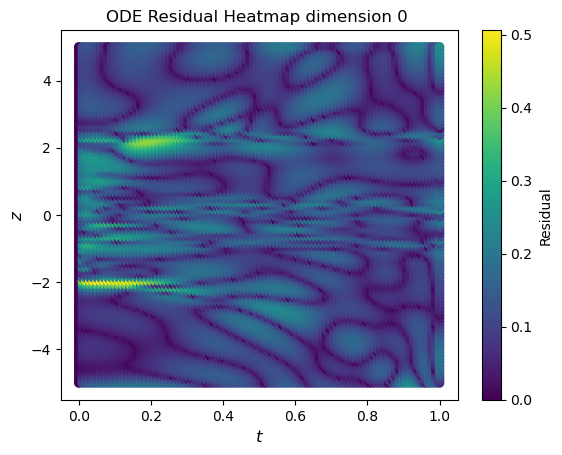

In [40]:
## Verifying PDE Compilance accross the domain :
# Create a grid of points
t = np.linspace(0, 1, 100)
z_0_test = np.linspace(-5,5,100)
z_1_test = np.linspace(-5,5,100)
z_2_test = np.linspace(-5,5,100)

z_test = np.array([z_0_test, z_1_test,z_2_test]).T

T_flat = torch.tensor(t, device=DEVICE, dtype=torch.float32).repeat_interleave(len(z_test))[:, None]  # [T*N,1]
Z_flat = torch.tensor(z_test, device=DEVICE, dtype=torch.float32).repeat(len(t), 1)  # [T*N,2]

#model = PhysicsNN(x0).to(device)
#model.load_state_dict(torch.load('RFDE_model_parameters.pth'))

x_predicted_PINN_n = x_function(model, T_flat, Z_flat)
x_predicted_solver = flow(torch.Tensor(z_test).to(DEVICE))
residue = f(model, T_flat, Z_flat)

plt.scatter(T_flat[:,0].detach().to('cpu').numpy(), Z_flat[:,0].detach().to('cpu').numpy(), c=np.sqrt(np.abs(residue[:,0].detach().to('cpu').numpy())), cmap='viridis')
plt.colorbar(label='Residual')
plt.xlabel('$t$', fontsize=12)
plt.ylabel('$z$', fontsize=12)
plt.title('ODE Residual Heatmap dimension 0 ')
plt.show()


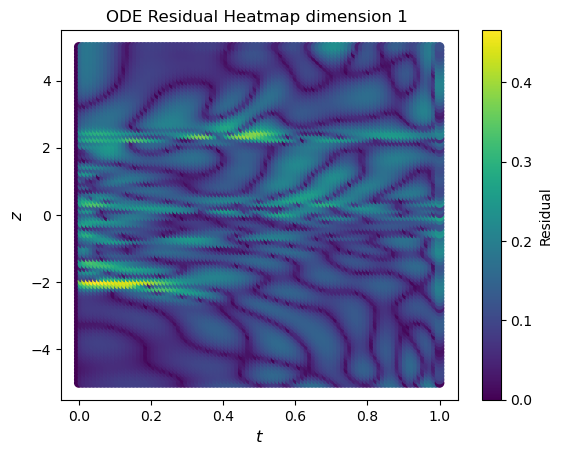

In [41]:
plt.scatter(T_flat[:,0].detach().to('cpu').numpy(), Z_flat[:,1].detach().to('cpu').numpy(), c=np.sqrt(np.abs(residue[:,1].detach().to('cpu').numpy())), cmap='viridis')
plt.colorbar(label='Residual')
plt.xlabel('$t$', fontsize=12)
plt.ylabel('$z$', fontsize=12)
plt.title('ODE Residual Heatmap dimension 1 ')
plt.show()

In [42]:
x_predicted_solver_numpy = np.array([t[0] for t in x_predicted_solver[0]])

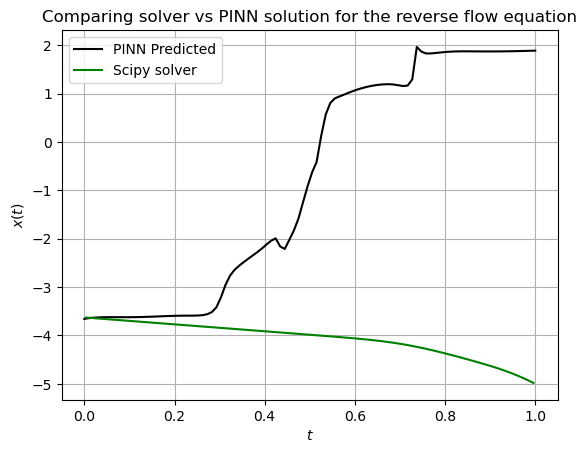

In [43]:
# Comparision of trained solver with traditional solver

t_eval = np.linspace(0, 1, 100)

# Plotting the results
#u_f = model(t_eval[:,None], xi_eval[:,None]).detach().to('cpu').numpy()
#t_f = t_eval.detach().to('cpu').numpy()*20
#u_f = u_f.detach().to('cpu').numpy()
plt.plot(t_eval,x_predicted_PINN_n.detach().to('cpu').numpy()[0:100,0] , color = 'k', label = "PINN Predicted")
plt.plot(x_predicted_solver[1],x_predicted_solver_numpy[:,0], color = 'g', label=f"Scipy solver")
#plt.scatter(x_u.detach().numpy(),y_u.detach().numpy(), label = "Initial",color ='r' )
plt.title("Comparing solver vs PINN solution for the reverse flow equation")
plt.ylabel(r"$x(t)$")
plt.xlabel(r"$t$")
#plt.ylim(-1,1)
plt.grid(True)
plt.legend()
#plt.savefig("/content/drive/MyDrive/Physics informed neural network/Harmonic_Oscilator.png", dpi = 100)
plt.show()


In [44]:
! nvidia-smi

Sun Jul 27 08:07:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:C3:00.0 Off |                    0 |
| N/A   47C    P0             48W /  250W |   22583MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [45]:
## Analysing the Trained Model :

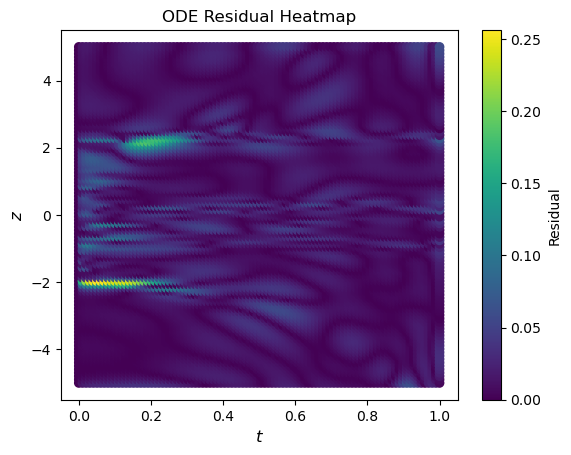

In [46]:
## Verifying PDE Compilance accross the domain :
# Create a grid of points

residue = f(model, T_flat, Z_flat)

plt.scatter(T_flat.detach().to('cpu').numpy()[:,0], Z_flat.detach().to('cpu').numpy()[:,0], c=(np.abs(residue.detach().to('cpu').numpy())[:,0]), cmap='viridis')
plt.colorbar(label='Residual')
plt.xlabel('$t$', fontsize=12)
plt.ylabel('$z$', fontsize=12)
plt.title('ODE Residual Heatmap')
plt.show()



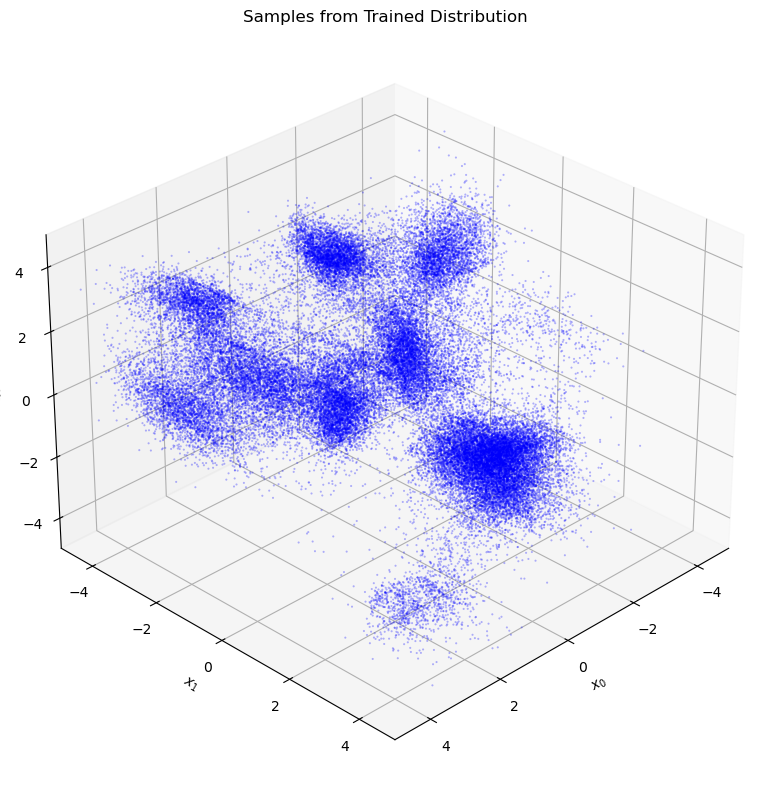

In [47]:
## plotting the  Sampled distribution 
#z = z_train.to(DEVICE)

z_evaluate = get_normal_sample(X0[:50000]).to(DEVICE)

t_0 = torch.zeros(z_evaluate.shape[0]).to(DEVICE)[:,None]

y_p = x_function(model,t_0, z_evaluate) 
plot3D(y_p.detach().cpu().numpy(), title = "Samples from Trained Distribution")

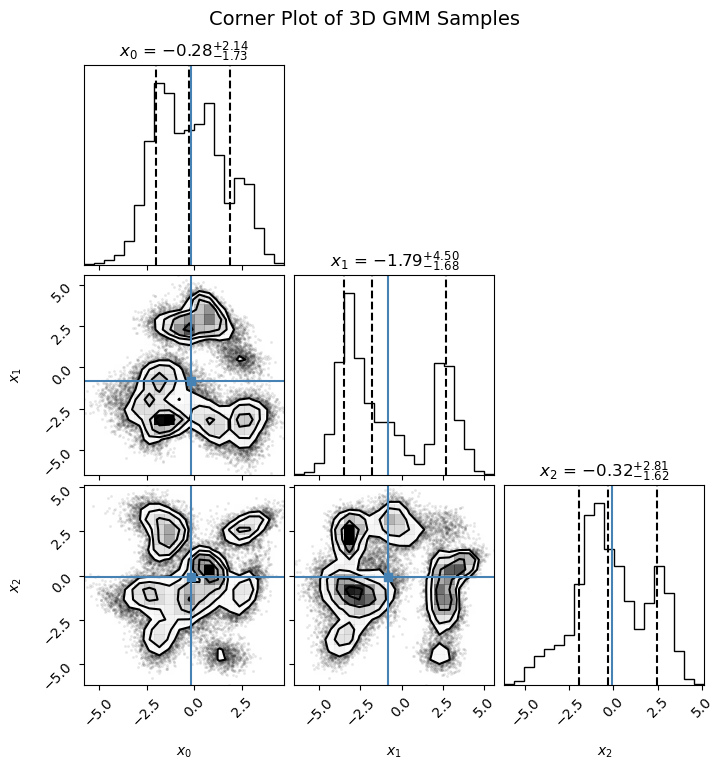

In [48]:
# Generate corner plot
fig = corner.corner(
    samples_3d,
    labels=["$x_0$", "$x_1$","$x_2$" ],
    truths=np.mean(samples_3d, axis=0),  # Optional: Mark true means
    quantiles=[0.16, 0.5, 0.84],  # Show 1-sigma ranges
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

plt.suptitle("Corner Plot of 3D GMM Samples", y=1.02, fontsize=14)
#plt.savefig("corner_plot.png", bbox_inches="tight")
plt.show()

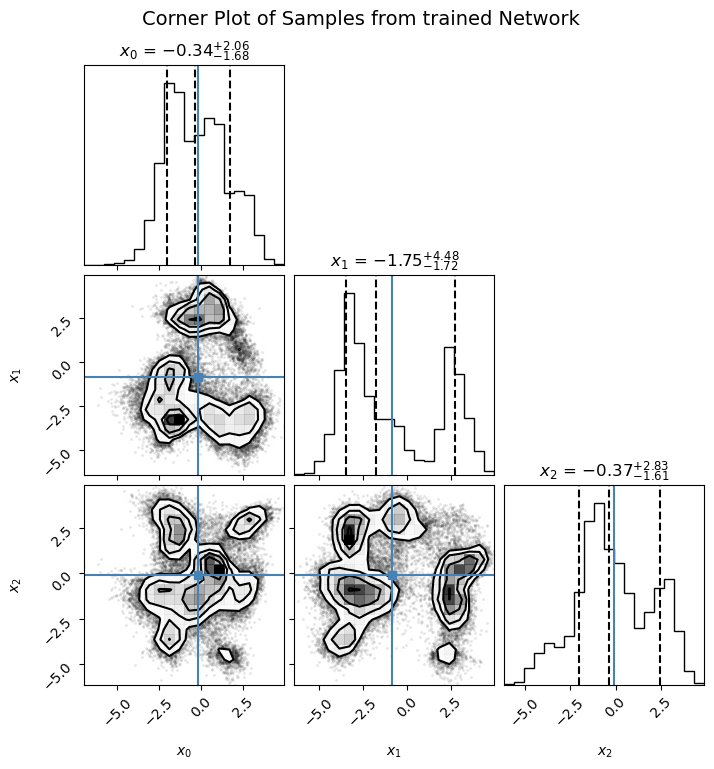

In [49]:
# Generate corner plot
fig = corner.corner(
    y_p.detach().cpu().numpy(),
    labels=["$x_0$", "$x_1$","$x_2$" ],
    truths=np.mean(samples_3d, axis=0),  # Optional: Mark true means
    quantiles=[0.16, 0.5, 0.84],  # Show 1-sigma ranges
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

plt.suptitle("Corner Plot of Samples from trained Network ", y=1.02, fontsize=14)
#plt.savefig("corner_plot.png", bbox_inches="tight")
plt.show()